<a href="https://colab.research.google.com/github/NSR9/Extensive-Vision-AI/blob/main/Assignment3/Assignment3_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Get Train Data
train_data = torchvision.datasets.MNIST(
    root='./data',
    train= True,
    download= True,
    transform = transforms.Compose(
        [transforms.ToTensor()]
    )
)

# Get Test Data
test_data = torchvision.datasets.MNIST(
    root='./data',
    train= False,
    download= True,
    transform = transforms.Compose(
        [transforms.ToTensor()]
    )
)

In [ ]:
len(train_data)

60000

In [ ]:
len(test_data)

10000

In [ ]:
# Generate Custom Dataset
class CustomDataSet(Dataset):
  def __init__(self, mnist_train_data):
    """
      For Loop Explanation:
        1. itearte through each row in dataset
        2. Generate a random number
        3. Add random plus mnist_label
        4. Append mnist_image_data, mnist_label, random_number and sum to data list
    """
    self.data = []
    for mnist_image, mnist_label in iter(mnist_train_data):
      random_number = np.random.randint(0, 9) # Generating a random number between 0 to 9
      sum_label = mnist_label + random_number
      # Generate one hot encoding vector using torch nn.functional package
      # https://pytorch.org/docs/master/generated/torch.nn.functional.one_hot.html
      encoded_random_number = F.one_hot(torch.tensor(random_number), num_classes=10)
      # Append All information into data
      self.data.append(
          (
              mnist_image,
              encoded_random_number,
              mnist_label,
              sum_label
           )
      )

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    mnist_image, random_number, mnist_label, sum_label = self.data[index]
    return mnist_image,random_number, mnist_label, sum_label

In [ ]:
final_train_data = CustomDataSet(train_data)
final_test_data = CustomDataSet(test_data)

In [ ]:
len(next(iter(final_train_data)))

4

In [ ]:
next(iter(final_train_data))[1].shape

torch.Size([10])

In [ ]:
next(iter(final_train_data))[0].shape

torch.Size([1, 28, 28])

In [ ]:
sample = next(iter(final_train_data))
mnist_image, random_number, mnist_label, sum_label = sample

== LABEL ==:  5
== Random Number ==:  tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
== Sum ==:  5


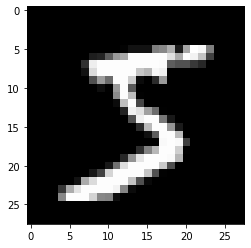

In [ ]:
plt.imshow(mnist_image.squeeze(), cmap='gray')
print("== LABEL ==: ", mnist_label)
print("== Random Number ==: ", random_number)
print("== Sum ==: ", sum_label)

In [ ]:
# Load Data
train_loader = torch.utils.data.DataLoader(
    dataset= final_train_data,
    batch_size= 128,
    shuffle= True
)

test_loader = torch.utils.data.DataLoader(
    dataset= final_test_data,
    batch_size= 128,
    shuffle= True
)

In [ ]:
len(next(iter(train_loader)))

4

In [ ]:
sample = next(iter(train_loader))
mnist_image, random_number, mnist_label, sum_label = sample

print("== Image Shape ==: ", mnist_image.shape)
print("== Random Number Shape ==: ", random_number.shape)
print("== Mnist Label Shape ==: ", mnist_label.shape)
print("== Sum Shape ==: ", sum_label.shape)

== Image Shape ==:  torch.Size([128, 1, 28, 28])
== Random Number Shape ==:  torch.Size([128, 10])
== Mnist Label Shape ==:  torch.Size([128])
== Sum Shape ==:  torch.Size([128])


In [ ]:
# Network Design
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(
        in_channels= 1,
        out_channels= 32,
        kernel_size= 3,
        padding=1
    ) 

    self.conv2 = nn.Conv2d(
        in_channels=32, 
        out_channels=64, 
        kernel_size=3,
        padding=1
    )  

    self.max_pool1 = nn.MaxPool2d(2, 2) 
                     
    self.conv3 = nn.Conv2d(
        in_channels= 64, 
        out_channels= 128, 
        kernel_size= 3,
        padding=1
    )  

    self.conv4 = nn.Conv2d(
        in_channels= 128, 
        out_channels= 256, 
        kernel_size= 3,
        padding=1
    )    

    self.max_pool2 = nn.MaxPool2d(2, 2)  
    
    self.conv5 = nn.Conv2d(
        in_channels= 256, 
        out_channels= 512, 
        kernel_size= 3
    )  

    self.conv6 = nn.Conv2d(
        in_channels= 512, 
        out_channels= 1024, 
        kernel_size= 3
    )  

    self.conv7 = nn.Conv2d(
        in_channels= 1024, 
        out_channels= 10,
        kernel_size= 3
    )  

    # out received from above layer is 10x1x1
    # send one hot encoded random vector
    # so total input features will become 20
    self.fc1 = nn.Linear(
        in_features= 20,
        out_features= 64
    )    

    self.fc2 = nn.Linear(
        in_features= 64,
        out_features= 19
    )


  def forward(self, mnist_image, random_number):
    mnist_image = self.conv1(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.conv2(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.max_pool1(mnist_image)

    mnist_image = self.conv3(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.conv4(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.max_pool2(mnist_image)

    mnist_image = self.conv5(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.conv6(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.conv7(mnist_image)

    mnist_image = mnist_image.reshape(-1, 10)

    # Concatenate encoded random number vector with reshaped mnist_image
    # 1x20
    random_number = torch.cat(
        (
            mnist_image,
            random_number
        ),
        dim= 1
    )

    # Pass concat vector to fully connected layers
    random_number = self.fc1(random_number)
    random_number = F.relu(random_number)
    random_number = self.fc2(random_number)

    return F.log_softmax(mnist_image), F.log_softmax(random_number)
 


In [ ]:
!pip install hiddenlayer


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
network = Network()
network.to(device)

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(1024, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=19, bias=True)
)

In [ ]:
# import hiddenlayer as h1

# h1.build_graph(network, torch.zeros([[1, 3, 28, 28], [1, 10]]))

In [ ]:
batch = next(iter(train_loader))
len(batch)

4

In [ ]:
mnist_images, random_numbers, mnist_labels, sum_labels = batch

print(mnist_images.shape, random_numbers.shape)

pred_1, pred_2 = network(mnist_images.to(device), random_numbers.to(device))

print(pred_1.shape, pred_2.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128, 10])
torch.Size([128, 10]) torch.Size([128, 19])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
torch.set_grad_enabled(True)

In [ ]:
optimizer = torch.optim.Adam(network.parameters())

In [ ]:
def get_num_correct(preds, labels):
  preds = torch.argmax(preds,dim=1)

  total_count = 0
  for i in range(len(preds)):
    if preds[i] == labels[i]:
      total_count += 1
  return total_count/len(preds)

In [ ]:
# Training Loop
for epoch in range(3):

    mnist_loss = 0
    sum_loss = 0
    total_loss = 0
    mnist_correct = 0
    sum_correct = 0
    mnist_accuracy = 0
    sum_accuracy = 0

    for idx, batch in enumerate(train_loader): # Get Batch
        mnist_images, random_numbers, mnist_labels, sum_label = batch 

        mnist_labels_predicted, sum_predicted = network(
            mnist_images.to(device), 
            random_numbers.to(device)
            ) # Pass Batch
        
        mnist_loss= F.cross_entropy(
            mnist_labels_predicted, 
            mnist_labels.to(device)
            )
        
        sum_loss = F.cross_entropy(
            sum_predicted,
            sum_label.to(device)
        )

        mnist_accuracy = get_num_correct(mnist_labels_predicted, mnist_labels.to(device))
        sum_accuracy = get_num_correct(sum_predicted, sum_label.to(device))


        # loss = torch.add(mnist_loss, sum_loss) # Calculate Loss
        # loss = mnist_loss
        optimizer.zero_grad()
        # sum_loss.backward() # Calculate Gradients
        
        # if mnist_accuracy < 0.95:
        mnist_loss.backward(retain_graph=True)
        # else:
        sum_loss.backward(retain_graph=False)
        # loss = mnist_loss + sum_loss
        # loss.backward()

        optimizer.step() # Update Weights

        # mnist_loss += mnist_loss.item()
        # sum_loss += sum_loss.item()
        # total_loss += loss.item()

        # mnist_accuracy = get_num_correct(mnist_labels_predicted, mnist_labels.to(device))
        # sum_accuracy = get_num_correct(sum_predicted, sum.to(device))

        # mnist_accuracy = mnist_correct/len(mnist_labels)
        # sum_accuracy = sum_correct/len(sum)

    # print(
    #     "EPOCH.      : {} MNIST LOSS.   : {} SUM LOSS.     : {}  TOTAL LOSS.   : {} MNIST CORRECT.: {} SUM CORRECT.  : {} MNIST ACCURACY: {} SUM ACCURACY. : {} ".format(
    #         epoch, 
    #         mnist_loss, 
    #         sum_loss,
    #         total_loss,
    #         mnist_correct,
    #         sum_correct,
    #         mnist_accuracy,
    #         sum_accuracy)
    # )
    print("EPOCH.   {}.  MNIST ACCURACY.   {}.  SUM ACCURACY.  {}".format(epoch, mnist_accuracy, sum_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH.   0.  MNIST ACCURACY.   0.9895833333333334.  SUM ACCURACY.  0.5833333333333334
EPOCH.   1.  MNIST ACCURACY.   1.0.  SUM ACCURACY.  0.96875
EPOCH.   2.  MNIST ACCURACY.   1.0.  SUM ACCURACY.  0.9895833333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH.   0.  MNIST ACCURACY.   0.9895833333333334.  SUM ACCURACY.  1.0
EPOCH.   1.  MNIST ACCURACY.   1.0.  SUM ACCURACY.  0.9791666666666666
EPOCH.   2.  MNIST ACCURACY.   1.0.  SUM ACCURACY.  0.9895833333333334
EPOCH.   3.  MNIST ACCURACY.   1.0.  SUM ACCURACY.  0.96875
EPOCH.   4.  MNIST ACCURACY.   1.0.  SUM ACCURACY.  0.9270833333333334


In [ ]:
# Test Loop
torch.set_grad_enabled(False)

test_mnist_accuracy = []
test_sum_accuracy = []

for idx, batch in enumerate(test_loader): # Get Batch
    mnist_images, random_numbers, mnist_labels, sum_label = batch 

    mnist_labels_predicted, sum_predicted = network(
        mnist_images.to(device), 
        random_numbers.to(device)
        ) # Pass Batch

    mnist_accuracy1 = get_num_correct(mnist_labels_predicted, mnist_labels.to(device))
    sum_accuracy1 = get_num_correct(sum_predicted, sum_label.to(device))

    test_mnist_accuracy.append(mnist_accuracy1)
    test_sum_accuracy.append(sum_accuracy1)
    
s1 = 0
m1 = 0
for i in range(len(test_sum_accuracy)):
  s1 += test_sum_accuracy[i]

for i in range(len(test_mnist_accuracy)):
  m1 += test_mnist_accuracy[i]


s_ac = round((s1/len(test_sum_accuracy)) * 100, 2)
m_ac = round((m1/len(test_mnist_accuracy)) * 100, 2)

print("MNIST ACCURACY.   {}.  SUM ACCURACY.  {}".format(m_ac, s_ac))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


MNIST ACCURACY.   99.21.  SUM ACCURACY.  99.15


In [ ]:
# Training Loop
for epoch in range(5):

    mnist_loss = 0
    sum_loss = 0
    total_loss = 0
    mnist_correct = 0
    sum_correct = 0
    mnist_accuracy = 0
    sum_accuracy = 0

    for idx, batch in enumerate(train_loader): # Get Batch
        mnist_images, random_numbers, mnist_labels, sum_label = batch 

        mnist_labels_predicted, sum_predicted = network(
            mnist_images.to(device), 
            random_numbers.to(device)
            ) # Pass Batch
        
        mnist_loss= F.cross_entropy(
            mnist_labels_predicted, 
            mnist_labels.to(device)
            )
        
        sum_loss = F.cross_entropy(
            sum_predicted,
            sum_label.to(device)
        )

        mnist_accuracy = get_num_correct(mnist_labels_predicted, mnist_labels.to(device))
        sum_accuracy = get_num_correct(sum_predicted, sum_label.to(device))


        # loss = torch.add(mnist_loss, sum_loss) # Calculate Loss
        # loss = mnist_loss
        optimizer.zero_grad()
        # sum_loss.backward() # Calculate Gradients

        loss = mnist_loss + sum_loss
        loss.backward()

        optimizer.step() # Update Weights

        # mnist_loss += mnist_loss.item()
        # sum_loss += sum_loss.item()
        # total_loss += loss.item()

        # mnist_accuracy = get_num_correct(mnist_labels_predicted, mnist_labels.to(device))
        # sum_accuracy = get_num_correct(sum_predicted, sum.to(device))

        # mnist_accuracy = mnist_correct/len(mnist_labels)
        # sum_accuracy = sum_correct/len(sum)

    # print(
    #     "EPOCH.      : {} MNIST LOSS.   : {} SUM LOSS.     : {}  TOTAL LOSS.   : {} MNIST CORRECT.: {} SUM CORRECT.  : {} MNIST ACCURACY: {} SUM ACCURACY. : {} ".format(
    #         epoch, 
    #         mnist_loss, 
    #         sum_loss,
    #         total_loss,
    #         mnist_correct,
    #         sum_correct,
    #         mnist_accuracy,
    #         sum_accuracy)
    # )
    print("EPOCH.   {}.  MNIST ACCURACY.   {}.  SUM ACCURACY.  {}".format(epoch, mnist_accuracy, sum_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH.   0.  MNIST ACCURACY.   1.0.  SUM ACCURACY.  0.65625
EPOCH.   1.  MNIST ACCURACY.   0.9895833333333334.  SUM ACCURACY.  0.96875
EPOCH.   2.  MNIST ACCURACY.   1.0.  SUM ACCURACY.  1.0
EPOCH.   3.  MNIST ACCURACY.   0.9791666666666666.  SUM ACCURACY.  0.9791666666666666
EPOCH.   4.  MNIST ACCURACY.   1.0.  SUM ACCURACY.  1.0


In [ ]:
# Training Loop
for epoch in range(2):

    mnist_loss = 0
    sum_loss = 0
    total_loss = 0
    mnist_correct = 0
    sum_correct = 0
    mnist_accuracy = 0
    sum_accuracy = 0

    for idx, batch in enumerate(train_loader): # Get Batch
        mnist_images, random_numbers, mnist_labels, sum_label = batch 

        mnist_labels_predicted, sum_predicted = network(
            mnist_images.to(device), 
            random_numbers.to(device)
            ) # Pass Batch
        
        mnist_loss= F.cross_entropy(
            mnist_labels_predicted, 
            mnist_labels.to(device)
            )
        
        sum_loss = F.cross_entropy(
            sum_predicted,
            sum_label.to(device)
        )

        mnist_accuracy = get_num_correct(mnist_labels_predicted, mnist_labels.to(device))
        sum_accuracy = get_num_correct(sum_predicted, sum_label.to(device))


        # loss = torch.add(mnist_loss, sum_loss) # Calculate Loss
        # loss = mnist_loss
        optimizer.zero_grad()
        # sum_loss.backward() # Calculate Gradients
        
        if mnist_accuracy < 0.95:
          mnist_loss.backward()
        else:
          sum_loss.backward()
        # loss = mnist_loss + sum_loss
        # loss.backward()

        optimizer.step() # Update Weights

        # mnist_loss += mnist_loss.item()
        # sum_loss += sum_loss.item()
        # total_loss += loss.item()

        # mnist_accuracy = get_num_correct(mnist_labels_predicted, mnist_labels.to(device))
        # sum_accuracy = get_num_correct(sum_predicted, sum.to(device))

        # mnist_accuracy = mnist_correct/len(mnist_labels)
        # sum_accuracy = sum_correct/len(sum)

    # print(
    #     "EPOCH.      : {} MNIST LOSS.   : {} SUM LOSS.     : {}  TOTAL LOSS.   : {} MNIST CORRECT.: {} SUM CORRECT.  : {} MNIST ACCURACY: {} SUM ACCURACY. : {} ".format(
    #         epoch, 
    #         mnist_loss, 
    #         sum_loss,
    #         total_loss,
    #         mnist_correct,
    #         sum_correct,
    #         mnist_accuracy,
    #         sum_accuracy)
    # )
    print("EPOCH.   {}.  MNIST ACCURACY.   {}.  SUM ACCURACY.  {}".format(epoch, mnist_accuracy, sum_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH.   0.  MNIST ACCURACY.   0.9791666666666666.  SUM ACCURACY.  0.4375
EPOCH.   1.  MNIST ACCURACY.   0.96875.  SUM ACCURACY.  0.90625


In [ ]:
from torchsummary import summary

summary(network, (1, 28, 28))

TypeError: ignored

In [ ]:
# Test Loop
torch.set_grad_enabled(False)

test_mnist_accuracy = []
test_sum_accuracy = []

for idx, batch in enumerate(test_loader): # Get Batch
    mnist_images, random_numbers, mnist_labels, sum_label = batch 

    mnist_labels_predicted, sum_predicted = network(
        mnist_images.to(device), 
        random_numbers.to(device)
        ) # Pass Batch
    
    # mnist_loss= F.cross_entropy(
    #     mnist_labels_predicted, 
    #     mnist_labels.to(device)
    #     )
    
    # sum_loss = F.cross_entropy(
    #     sum_predicted,
    #     sum.to(device)
    # )

    mnist_accuracy1 = get_num_correct(mnist_labels_predicted, mnist_labels.to(device))
    sum_accuracy1 = get_num_correct(sum_predicted, sum_label.to(device))

    test_mnist_accuracy.append(mnist_accuracy1)
    test_sum_accuracy.append(sum_accuracy1)


# type(test_mnist_accuracy), type(test_sum_accuracy)
# sum(1+1)
s1 = 0
m1 = 0
for i in range(len(test_sum_accuracy)):
  s1 += test_sum_accuracy[i]

for i in range(len(test_mnist_accuracy)):
  m1 += test_mnist_accuracy[i]


s_ac = round((s1/len(test_sum_accuracy)) * 100, 2)
m_ac = round((m1/len(test_mnist_accuracy)) * 100, 2)

print("MNIST ACCURACY.   {}.  SUM ACCURACY.  {}".format(m_ac, s_ac))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


MNIST ACCURACY.   98.72.  SUM ACCURACY.  97.71


TypeError: ignored